In [1]:
#EDIT ME to change target subreddit...
target_subreddit = "Naruto" # scraped data includes: ['Naruto', 'BokuNoHeroAcademia', 'anime', 'manga', 'comicbooks',
                                                    # 'StarWars', 'startrek', 'LonghornNation', 'cfb', 'Genshin_Impact']
scrape_type = "submission"  # set to "submission" or "comment"

# Import

In [2]:
import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
# from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [3]:
# Read in data
all_data = pd.read_csv(f'./data/{target_subreddit}_{scrape_type}s.csv')

In [4]:
all_data.head()

,Unnamed: 0,subreddit,selftext,author_fullname,gilded,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,...,url_overridden_by_dest,preview,media_metadata,is_gallery,gallery_data,poll_data,crosspost_parent_list,crosspost_parent,edited_on,author_cakeday
0,0,Naruto,He killed multiple people on occasion. I get h...,t2_jkj0lk81,0,Sasuke… Right should he have been forgiven?,"[{'e': 'text', 't': 'Question'}]",r/Naruto,False,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Naruto,NaN,t2_vka3weio,0,Why wouldn’t kishi go deeper into the backstor...,"[{'e': 'text', 't': 'Question'}]",r/Naruto,False,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Naruto,[removed],t2_jkj0lk81,0,Sasuke….,"[{'e': 'text', 't': 'Question'}]",r/Naruto,False,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Naruto,NaN,t2_83rdhbm4,0,My ranking of all Naruto/Boruto canon arcs,"[{'e': 'text', 't': 'Anime'}]",r/Naruto,False,6.0,...,https://i.redd.it/yd4gqxd8lfla1.png,{'images': [{'source': {'url': 'https://previe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Naruto,NaN,t2_vgha5aex,0,Nah but can someone actually explain wtf Minat...,"[{'e': 'text', 't': 'Question'}]",r/Naruto,False,6.0,...,https://i.redd.it/yi4a48shkfla1.png,{'images': [{'source': {'url': 'https://previe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Choosing a sub-set of columns worth keeping for (possible) analysis

In [5]:
all_data.columns

Index(['Unnamed: 0', 'subreddit', 'selftext', 'author_fullname', 'gilded',
       'title', 'link_flair_richtext', 'subreddit_name_prefixed', 'hidden',
       'pwls', 'link_flair_css_class', 'thumbnail_height', 'top_awarded_type',
       'hide_score', 'quarantine', 'link_flair_text_color', 'upvote_ratio',
       'author_flair_background_color', 'subreddit_type',
       'total_awards_received', 'media_embed', 'thumbnail_width',
       'author_flair_template_id', 'is_original_content', 'secure_media',
       'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed',
       'link_flair_text', 'score', 'is_created_from_ads_ui', 'author_premium',
       'thumbnail', 'edited', 'author_flair_css_class',
       'author_flair_richtext', 'gildings', 'content_categories', 'is_self',
       'link_flair_type', 'wls', 'removed_by_category', 'author_flair_type',
       'domain', 'allow_live_comments', 'suggested_sort', 'view_count',
       'archived', 'no_follow', 'is_crosspostable', 'pinn

In [6]:
# columns investigated one-by-one, systematically... no real valuable data found other than columns used below

# all_data['gildings'].value_counts()
# all_data[all_data['gildings']!="{}"]

In [7]:
df = all_data[['subreddit','selftext', 'author_fullname', 'title', 'upvote_ratio', 
              'is_reddit_media_domain', 'domain', 'over_18', 'spoiler', 'id', 
              'author', 'num_comments', 'created_utc', 'is_video'
             ]].copy()   #used .copy() to reduce number of warnings later

df.head()

,subreddit,selftext,author_fullname,title,upvote_ratio,is_reddit_media_domain,domain,over_18,spoiler,id,author,num_comments,created_utc,is_video
0,Naruto,He killed multiple people on occasion. I get h...,t2_jkj0lk81,Sasuke… Right should he have been forgiven?,1.0,False,self.Naruto,False,False,11gohb0,Pete_Dickson71096,0,1677810068,False
1,Naruto,NaN,t2_vka3weio,Why wouldn’t kishi go deeper into the backstor...,1.0,False,self.Naruto,False,False,11gof6j,Ok-Seaworthiness3719,0,1677809908,False
2,Naruto,[removed],t2_jkj0lk81,Sasuke….,1.0,False,self.Naruto,False,False,11gof2a,Pete_Dickson71096,0,1677809900,False
3,Naruto,NaN,t2_83rdhbm4,My ranking of all Naruto/Boruto canon arcs,1.0,True,i.redd.it,False,False,11gnz51,Accomplished-Leg-362,0,1677808731,False
4,Naruto,NaN,t2_vgha5aex,Nah but can someone actually explain wtf Minat...,1.0,True,i.redd.it,False,False,11gnxbb,Small_Balls_69,0,1677808592,False


# Create new columns that might be useful

In [8]:
# Convert UTC times to human-readable

df['created_datetime'] = pd.to_datetime(df['created_utc'], unit='s')

#Reference: https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

In [9]:
# Make a combined column of seltext + title, for combined processing

cond1 = df['selftext'].notna()
cond2 = df['selftext'] != '[removed]'

df['combined_text'] = np.where((cond1 & cond2),
                                df['title'] + " " + df['selftext'],
                                df['title'])      #if selftext is blank or [removed], just use only the title

In [10]:
df["combined_text_length"] = df['combined_text'].str.len()

In [11]:
df["combined_wordcount"] = df['combined_text'].str.split(" ").str.len()

# Text normalization (lemmatizing, tokenizing, stop words)

In [12]:
# Lemmatizing 
# Reference: Lesson 504

wn = WordNetLemmatizer()

def custom_lemmatize(word, tag):
    mapper = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    pos = mapper.get(tag[0])
    
    return wn.lemmatize(word, pos) if pos else word

df['lemmatized_text'] = ""

for i in range(df.shape[0]):
    df['lemmatized_text'][i] = \
        " ".join([custom_lemmatize(word, tag) for word, tag in nltk.pos_tag( df['combined_text'][i].split(" "))])
    
    #Runs slow & gives a warning, but works

C:\Users\panda\AppData\Local\Temp\ipykernel_42400\3621847600.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized_text'][i] = \


In [13]:
# Tokenizing & stopword removal AFTER lemmatizing
# Reference: Lesson 504

tokenizer = RegexpTokenizer('\w+')

df['tokenized_text'] = ""

for i in range(df.shape[0]):
    my_text_tokens = tokenizer.tokenize(df['lemmatized_text'][i].lower())
    my_text_tokens_ns = [token for token in my_text_tokens if token not in stopwords.words("english")]
    recombined_text = " ".join(my_text_tokens_ns)
    df['tokenized_text'][i] = recombined_text
    
    #Runs slow & gives a warning, but works

C:\Users\panda\AppData\Local\Temp\ipykernel_42400\3578492394.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text'][i] = recombined_text


In [14]:
df.head()

,subreddit,selftext,author_fullname,title,upvote_ratio,is_reddit_media_domain,domain,over_18,spoiler,id,author,num_comments,created_utc,is_video,created_datetime,combined_text,combined_text_length,combined_wordcount,lemmatized_text,tokenized_text
0,Naruto,He killed multiple people on occasion. I get h...,t2_jkj0lk81,Sasuke… Right should he have been forgiven?,1.0,False,self.Naruto,False,False,11gohb0,Pete_Dickson71096,0,1677810068,False,2023-03-03 02:21:08,Sasuke… Right should he have been forgiven? He...,151,27,Sasuke… Right should he have be forgiven? He k...,sasuke right forgiven kill multiple people occ...
1,Naruto,NaN,t2_vka3weio,Why wouldn’t kishi go deeper into the backstor...,1.0,False,self.Naruto,False,False,11gof6j,Ok-Seaworthiness3719,0,1677809908,False,2023-03-03 02:18:28,Why wouldn’t kishi go deeper into the backstor...,110,19,Why wouldn’t kishi go deeply into the backstor...,kishi go deeply backstory sakumo father import...
2,Naruto,[removed],t2_jkj0lk81,Sasuke….,1.0,False,self.Naruto,False,False,11gof2a,Pete_Dickson71096,0,1677809900,False,2023-03-03 02:18:20,Sasuke….,8,1,Sasuke….,sasuke
3,Naruto,NaN,t2_83rdhbm4,My ranking of all Naruto/Boruto canon arcs,1.0,True,i.redd.it,False,False,11gnz51,Accomplished-Leg-362,0,1677808731,False,2023-03-03 01:58:51,My ranking of all Naruto/Boruto canon arcs,42,7,My ranking of all Naruto/Boruto canon arc,ranking naruto boruto canon arc
4,Naruto,NaN,t2_vgha5aex,Nah but can someone actually explain wtf Minat...,1.0,True,i.redd.it,False,False,11gnxbb,Small_Balls_69,0,1677808592,False,2023-03-03 01:56:32,Nah but can someone actually explain wtf Minat...,202,31,Nah but can someone actually explain wtf Minat...,nah someone actually explain wtf minato kunai ...


In [15]:
df.shape

(4887, 20)

In [16]:
cvec1 = CountVectorizer(stop_words="english")
cvec1.fit(df['tokenized_text'])
X_train_cvectorized = cvec1.transform(df['tokenized_text'])

X_train_df = pd.DataFrame(X_train_cvectorized.todense(), columns = cvec1.get_feature_names_out())
top15 = X_train_df.sum().sort_values(ascending=False).head(15)
top15

naruto       3259
sasuke       1287
like         1165
think         910
know          746
amp           742
make          703
use           682
fight         668
itachi        663
character     622
kakashi       588
boruto        540
time          529
obito         525
dtype: int64

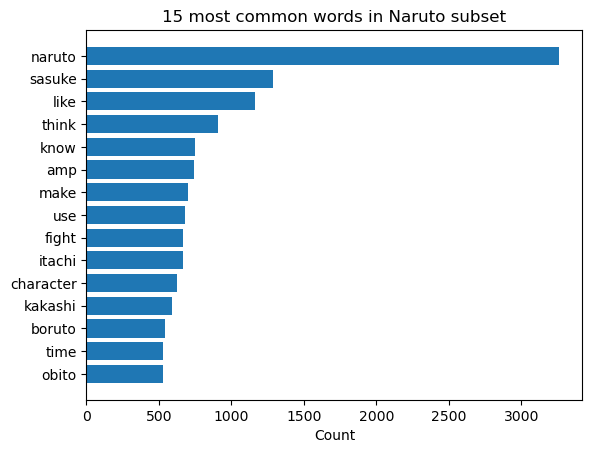

In [17]:
plt.barh(top15.index[::-1], top15[::-1],label=top15) ;
plt.title(f'15 most common words in {target_subreddit} subset')
plt.xlabel('Count');

# Write output to csv

In [18]:
df.to_csv(f'./data/{target_subreddit}_{scrape_type}s_preprocessed.csv', index=False)